<a href="https://colab.research.google.com/github/Sarnapa/Credit-Card-Fraud-Detection/blob/main/Notebooks/CreditCardFraudDetection_AnomalyDetectionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Temat zadania: analityczny - detekcja anomalii



**Autorzy: Michał Bartnicki, Michał Piotrak**

**Kod zadania: DAz11**

**Wybrany zbiór danych: [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)**

## Instrukcja uruchomienia
Należy uruchomić cały notatnik poprzez wywołanie funkcji "Run all". Notatnik ustawiony jest w trybie szybkim, czas trwania to około 12 minut. Po tym czasie wygenerują się wszystkie wykresy i wyniki. W trybie szybkim kod uruchamiany jest na uszczuplonym zbiorze danych i parametrów, natomiast wykresy i wyniki generowane są z wcześniej zapisanych w plikach modeli i wyników.

**TODO: ❗ Potwierdzić czas trwania**

#Wprowadzenie

Celem pracy jest porównanie skuteczności modeli uczenia maszynowego z podziałem na dwie grupy:
- uczenie nadzorowane
- uczenie nienadzorowane

w działaniu na wysoce niezbilansowanym zbiorze danych, w klasyfikacji binarnej.
Zbadano następujące algorytmy: las losowy, drzewo decyzyjne, jednoklasowy SVM, las izolacyjny, lokalny czynnik odstający.

# Przygotowanie oraz konfiguracja środowiska uruchomieniowego

W tej sekcji umieszczamy listę zmiennych konfiguracyjnych, które mają wpływ na wykonanie przetwarzania zawartego w danym notatniku. Poza tym, przygotowaliśmy fragment skryptu, który zadba o instalację niezbędnych bibliotek zewnętrznych.

In [ ]:
# Lista zmiennych konfiguracyjnych

# Flaga, której ustawienie umożliwia szybsze wykonanie przetwarzania zawartego w notatniku
# w celu demonstracyjnym. Wiąże się z:
# 1. Wczytaniem mniejszej ilości danych ze zbioru źródłowego.
# 2. Wykonaniem mniejszej liczby iteracji w k krzyżowej walidacji.
# 3. Wykonaniem mniejszej liczby iteracji w strojenia parametrów, ze względu na mniejszą liczbę podanych wartości parametrów.
# 4. Jeśli w runtime, mamy już wynik k krzyżowej walidacji bądź wytrenowany model, to zostanie on wczytany z pliku.
QUICK_MODE = True
# Procent danych, który bierzemy pod uwagę przy pracy w trybie QUICK_MODE
QUICK_MODE_DATA_PERCENTAGE = 0.05

# Liczba foldów (warstw, na które został podzielony wejściowy zbiór danych) w k-krotnej walidacji
CV_FOLDS_COUNT = 5
if QUICK_MODE:
  CV_FOLDS_COUNT = 2

# Flaga, której ustawienie powoduje wczytanie pliku z rezultatami strojenia parametrów dla danego algorytmu,
# który został wygenerowany wcześniej, zazwyczaj na większym zbiorze danych
LOAD_PARAMS_TUNE_RESULTS_FROM_MASTER_FILE = True

# Flaga, która określa, czy chcemy załadować przygotowany wcześniej model
LOAD_PRETRAINED_MODEL = True

# Flaga, która umożliwia ograniczenie rozmiaru zbioru treningowego do określonego procentu danych pierwotnego zbioru treningowego.
# Ma to zagwarantować lepszą wydajność oraz jakość w przypadku trenowania niektórych modeli.
# Należy pamiętać, że dane ograniczenie wpływa jedynie na zbiór treningowy, a nie na zbiór testowy.
LIMIT_TRAINING_DATA_SIZE_MODE = False
LIMIT_TRAINING_DATA_SIZE_PERCENTAGE = 0.2

SEED = 42

# Zainstalowanie niezbędnych bibliotek
try:
  import gdown
except ImportError:
  !pip install -q gdown

try:
  import imblearn
except ImportError:
  !pip install -q imbalanced-learn

try:
  import joblib
except ImportError:
    !pip install -q joblib

try:
  import matplotlib.pyplot
except ImportError:
  !pip install -q matplotlib

try:
  import numpy as np
except ImportError:
  !pip install -q numpy

try:
  import pandas as pd
except ImportError:
  !pip install -q pandas

try:
  import seaborn as sns
except ImportError:
  !pip install -q seaborn

try:
  import sklearn
except ImportError:
  !pip install -q scikit-learn

from google.colab import data_table

data_table.enable_dataframe_formatter()

Załadowanie plików:

In [ ]:
# Generalnie podajemy ścieżki do pliku tymczasowego z wynikami, który został wygenerowany w ramach danej sesji
# oraz do pliku wcześniej wygenerowanego, który zawiera dane bardziej reprezentatywne
# Także inicjalizacja pewnych zmiennych związanych z procesem strojenia parametrów oraz ewaluacją danego modelu
oc_svm_model_name = "oc_svm"
oc_svm_filtered_train_df_model_name = "oc_svm_filtered_train_df"
oc_svm_tune_results_tmp_file_path = f"results-{oc_svm_model_name}.csv"
oc_svm_tune_results_master_file_path = f"Results/results-{oc_svm_model_name}-33.csv"
oc_svm_runtime_model_file_path=f"{oc_svm_model_name}.joblib"
oc_svm_runtime_model_filtered_train_df_file_path=f"{oc_svm_filtered_train_df_model_name}.joblib"
oc_svm_pretrained_model_file_path=f"Results/{oc_svm_model_name}.joblib"
oc_svm_params_runtime_tune_results = None
oc_svm_params_full_tune_results = None
oc_svm_runtime_model_filtered_train_df_evaluation_result = None
oc_svm_runtime_model_evaluation_result = None
oc_svm_full_model_evaluation_result = None

isolation_forest_model_name = "isolation_forest"
isolation_forest_filtered_train_df_model_name = "isolation_forest_filtered_train_df"
isolation_forest_tune_results_tmp_file_path = f"results-{isolation_forest_model_name}.csv"
isolation_forest_tune_results_master_file_path = f"Results/results-{isolation_forest_model_name}.csv"
isolation_forest_runtime_model_file_path=f"{isolation_forest_model_name}.joblib"
isolation_forest_runtime_model_filtered_train_df_file_path=f"{isolation_forest_filtered_train_df_model_name}.joblib"
isolation_forest_pretrained_model_file_path=f"Results/{isolation_forest_model_name}.joblib"
isolation_forest_params_runtime_tune_results = None
isolation_forest_params_full_tune_results = None
isolation_forest_runtime_model_evaluation_result = None
isolation_forest_runtime_model_filtered_train_df_evaluation_result = None
isolation_forest_full_model_evaluation_result = None

lof_model_name = "lof"
lof_filtered_train_df_model_name = "lof_filtered_train_df"
lof_tune_results_tmp_file_path = f"results-{lof_model_name}.csv"
lof_tune_results_master_file_path = f"Results/results-{lof_model_name}.csv"
lof_runtime_model_file_path=f"{lof_model_name}.joblib"
lof_runtime_model_filtered_train_df_file_path=f"{lof_filtered_train_df_model_name}.joblib"
lof_pretrained_model_file_path=f"Results/{lof_model_name}.joblib"
lof_params_runtime_tune_results = None
lof_params_full_tune_results = None
lof_runtime_model_evaluation_result = None
lof_runtime_model_filtered_train_df_evaluation_result = None
lof_full_model_evaluation_result = None

# Opis danych oraz ich wczytanie


Wybrany zbiór zawiera zanonimizowane informacje o transakcjach dokonanych za pomocą kart kredytowych przez Europejczyków we wrześniu 2013 roku przez okres dwóch dni.

Transakcje są opisane przy pomocy następujących cech:


* Wektor cech *\[V1, …, V28\]* - cechy transakcji po transformacji PCA,
* *Time* - upływ czasu w sekundach pomiędzy pierwszą a określoną transakcją (bez transformacji PCA),
* *Amount* - kwota transakcji (bez transformacji PCA),
* *Class* - klasa transakcji, wartość ”1” - transakcja fałszywa (oszustwo), wartość ”0” - transakcja uczciwa.







TODO ❗ Opis czemu UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL

In [ ]:
from enum import Enum

UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL = -1

class Transaction(Enum):
    VALID_TRANSACTION = (0, "Transakcja regularna")
    FRAUD = (1, "Oszustwo")

    def __init__(self, value, label):
        self._value_ = value
        self.label = label

    @classmethod
    def to_string(cls, val):
        """
        Zwraca postać tekstową etykiety.
        """
        for member in cls:
            if member.value == val:
                return member.label
        return str(val)

# Tworzymy mapę: {0: "Transakcja regularna", 1: "Oszustwo"}, która ułatwi nam interpretację danych / wyników
class_labels_map = {t.value: t.label for t in Transaction}

Z powodów praktycznych, postanowiliśmy udostępnić dany zbiór danych na własnym dysku Google Drive i stamtąd go pobierać. Korzystając z Kaggle API, musielibyśmy zadbać o kwestie uwierzytelnienia, co uznaliśmy za ewentualne źródło problemów.

Zadbaliśmy także o to, żeby plik pobierać na środowisko uruchomieniowe jeden raz w trakcie jego działania.

Poniżej zawarliśmy kod umożliwiający wczytanie danych, odpowiednie ich zmapowanie wynikające ze specyfiki metod nienadzorowanych oraz prezentację trzech pierwszych wierszy, aby lepiej zdać sobie sprawę, jak konkretne dane wyglądają.

In [ ]:
import os

# ID pliku z Google Drive
file_id = "14HSXm9CDBA0DxLfSxGCgXQxUXyBxvfno"
output_path = "creditcard.csv"

# Pobierz tylko, jeśli pliku jeszcze nie ma
if not os.path.exists(output_path):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, output_path, quiet=False)
else:
    print("Plik ze zbiorem danych już istnieje lokalnie.")

if not os.path.exists('Results'):
  !gdown --id 1daNwXGml76GJgdsZ5s5urxgMgPofyHs9 --output Results --folder
else:
  print("Folder Results już istnieje. Nie pobieram")

# Wczytaj do DataFrame
df = pd.read_csv(output_path)

df.head(3)

Plik ze zbiorem danych już istnieje lokalnie.
Folder Results już istnieje. Nie pobieram


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


Poniżej przedstawiamy krótką charakterystykę danych.
Warto zauważyć, że zbiór jest wysoce niezbalansowany.

In [ ]:
print("Liczba atrybutów:", df.shape[1] - 1)
print("Całkowita liczba transakcji:", df.shape[0], end='\n\n')
print("Odsetek oszustw i transakcji regularnych w całym zbiorze:\n\n",
      df['Class'].value_counts(normalize=True).rename(index=class_labels_map), end='\n\n')
print("Całkowita liczba oszustw i transakcji regularnych:\n\n", df['Class'].value_counts().rename(index=class_labels_map))


Liczba atrybutów: 30
Całkowita liczba transakcji: 284807

Odsetek oszustw i transakcji regularnych w całym zbiorze:

 Class
Transakcja regularna    0.998273
Oszustwo                0.001727
Name: proportion, dtype: float64

Całkowita liczba oszustw i transakcji regularnych:

 Class
Transakcja regularna    284315
Oszustwo                   492
Name: count, dtype: int64


# Przygotowanie danych




Zgodnie z tym co planowaliśmy, aby zwiększyć prawdopodobieństwo uzyskania jak najlepszych rezultatów, przeprowadzimy należyty preprocessing zbioru wejściowego.

Będzie on składał się z następujących etapów:


* sprawdzenia, czy mamy w zbiorze jakiekolwiek braki danych czy duplikaty,
* skalowania cech *Time* oraz *Amount* (w wyniku zastosowania transformacji PCA, wektor cech *\[V1, ..., V28\]* powinien być uprzednio odpowiednio wyskalowany),
* pomimo zastosowania już transformacji PCA na części parametrów, zbadamy jeszcze korelacje pomiędzy nimi, w celu potencjalnej redukcji wymiarowości.

Poza tym, jeśli użytkownik tego notatnika postanowi działać z ustawioną flagą *QUICK_MODE*, przed odpowiednim preprocessingiem, nastąpi ograniczenie ilościowe wejściowego zbioru danych do ustalonego procentu całości, którego wartość możemy podać w sekcji **Przygotowanie oraz konfiguracja środowiska uruchomieniowego**. Przy tej operacji, zadbamy o zachowanie proporcji klas.



## Ograniczenie zbioru danych w trybie *QUICK_MODE*

Tryb *QUICK_MODE* należy uruchomić w przypadku, gdy zależy nam na szybkiej demonstracji całego rozwiązania.

Włączenie tego trybu zmniejsza też liczbę foldów otrzymanych w procesie k-krotnej walidacji krzyżowej. W celu zobaczenia, jak się dokładnie zmienia dana wartość, należy wrócić do rozdziału **Przygotowanie oraz konfiguracja środowiska uruchomieniowego**.

TODO: Napisać jeszcze o LIMIT_DATASET_SIZE_MODE

In [ ]:
# Do losowania wskazanego procentu danych, z zachowaniem proporcji klas
def stratified_sample(df, frac=0.2, seed=SEED):
    sampled_parts = []
    for label in df["Class"].unique():
        part = df[df["Class"] == label].sample(frac=frac, random_state=seed)
        sampled_parts.append(part)
    return pd.concat(sampled_parts).sample(frac=1, random_state=seed).reset_index(drop=True)

## Usuwanie duplikatów

Zbiór posiada następującą liczbę duplikatów:



In [ ]:
duplicates = df.duplicated(keep='first')
duplicates_count = duplicates.sum()
print(duplicates_count)

1081


Oczywiście, należy je usunąć ze zbioru, co czyni poniższy kod:

In [ ]:
df.drop_duplicates(inplace=True)
print("Usunięto duplikaty. Pozostało transakcji w zbiorze:", df.shape[0])


Usunięto duplikaty. Pozostało transakcji w zbiorze: 283726


## Sprawdzanie brakujących danych (NaN / null)
Poniżej następujące weryfikacji, czy mamy w zbiorze egzemplarze, których jakieś atrybuty przyjmują wartości puste bądź nieokreślone:

In [ ]:
missing_data = df.isnull().values.any()
print(f"Czy zbiór zawiera brakujące dane? Wynik walidacji - {missing_data}")


Czy zbiór zawiera brakujące dane? Wynik walidacji - False


## Skalowanie atrybutów *Time* oraz *Amount*

Większość atrybutów została już wcześniej przeskalowana w wyniku transformacji PCA. Pozostało wykonać to samo dla kolumn:
- *Time*
- *Amount*

W tym celu wykorzystamy [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) z biblioteki scikit-learn, który jest odporny na wartości odstające.

In [ ]:
from sklearn.preprocessing import RobustScaler

if set(['Amount','Time']).issubset(df.columns):
  scaler = RobustScaler()
  amount_scaled = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
  time_scaled = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
  df.drop(['Time', 'Amount'], axis=1, inplace=True)

  df.insert(1, 'time_scaled', time_scaled)
  df.insert(0, 'amount_scaled', amount_scaled)

print("Kolumny Amount i Time zostały przeskalowane:")
df.head(3)

Kolumny Amount i Time zostały przeskalowane:


,amount_scaled,V1,time_scaled,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.774718,-1.359807,-0.995290,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.268530,1.191857,-0.995290,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.959811,-1.358354,-0.995279,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0


## Redukcja wymiarowości
Według opisu zbioru danych, dane przeszły transformację PCA, która jest techniką
redukcji wymiarowości, co wskazuje na brak konieczności dalszych redukcji.
Sprawdzenie korelacji wszystkich par kolumn potwierdza nasze przypuszczenia.

In [ ]:
correlation_matrix = df.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highest_correlation = upper_triangle.max().max()

print(f"Najwyższa korelacja między dwoma dowolnymi parami atrybutów: {highest_correlation}")

Najwyższa korelacja między dwoma dowolnymi parami atrybutów: 0.5334280139266703


In [ ]:
# Mniejszy zbiór danych do szybszego testowania z zachowaniem proporcji klas
if QUICK_MODE:
  full_df = df.copy()
  df = stratified_sample(df, frac=QUICK_MODE_DATA_PERCENTAGE)

## Dostępne metody samplingu

In [ ]:
from enum import Enum
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Enum do wyboru metody samplingu
class SamplingMethod(Enum):
  NONE = 0
  UNDER = 1
  OVER = 2


  @staticmethod
  def from_string(string: str):
      return SamplingMethod[string.split(".")[-1]]

  def to_string(self):
      if self == SamplingMethod.NONE:
          return "Brak próbkowania"
      elif self == SamplingMethod.UNDER:
          return "Undersampling"
      elif self == SamplingMethod.OVER:
        return "Oversampling"

def get_sampler(sampling_method: SamplingMethod, sampling_strategy: float = 1.0, random_seed: int = SEED):
    if sampling_method == SamplingMethod.UNDER:
        sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_seed)
    elif sampling_method == SamplingMethod.OVER:
        sampler = SMOTE(sampling_strategy=sampling_strategy, random_state=random_seed)
    else:
        sampler = None

    return sampler

## Metoda przygotowująca podziały zbioru danych

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split

# Klasa reprezentująca podział danych
class DataSplit:
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

# Funkcja przygotowująca dane
def prepare_train_test_data_splits(
    data: pd.DataFrame,
    use_cv: bool = True,
    k: int = 5,
    test_data_size: float = 0.2,
    sampling_method: SamplingMethod = SamplingMethod.NONE,
    sampling_strategy: float = 1.0,
    random_seed: int = SEED
):
    """
    Przygotowuje dane do trenowania modeli z opcją k-krotnej walidacji i samplingu.

    Parametry:
    - data: DataFrame z danymi wejściowymi, gdzie kolumna "Class" jest etykietą
    - use_cv: czy używać k-krotnej walidacji (domyślnie True)
    - k: liczba foldów (warstw, na które został podzielony wejściowy zbiór danych) w k-krotnej walidacji (domyślnie 5)
    - test_data_size: rozmiar zbioru testowego (domyślnie 0.2, czyli 20% danych)
    - sampling_method: metoda samplingu (domyślnie SamplingMethod.NONE)
    - sampling_strategy: proporcja liczby egzemplarzy klasy mniejszościowej do klasy większościowej (lub na odwrót) po samplingu (domyślnie 1.0, w obu klasach będzie tyle samo przykładów)
    - random_seed: ziarno dla generatora liczb losowych (domyślnie 42)

    Zwraca:
    - Listę DataSplit: jeden element przy use_cv=False, k elementów przy use_cv=True
    """

    x = data.drop(columns=["Class"])
    y = data["Class"]

    sampler = get_sampler(sampling_method, sampling_strategy, random_seed)

    data_splits = []
    if use_cv:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_seed)

        for train_idx, test_idx in skf.split(x, y):
            x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            if sampler:
                x_train, y_train = sampler.fit_resample(x_train, y_train)

            data_splits.append(DataSplit(x_train, x_test, y_train, y_test))
    else:
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_data_size, stratify=y, random_state=random_seed
        )
        if sampler:
            x_train, y_train = sampler.fit_resample(x_train, y_train)

        data_splits.append(DataSplit(x_train, x_test, y_train, y_test))

    return data_splits

## Metoda do wizualizacji rozkładu klas w danych zbiorach  

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(data_splits, plot_title="Rozkład klas"):
    """
    Rysuje wykresy słupkowe pokazujące rozkład klas w zbiorach danych.

    Parametry:
    - data_splits: obiekt DataSplit albo lista obiektów DataSplit
    - plot_title: tytuł wykresu (domyślnie "Rozkład klas")
    """

    if not isinstance(data_splits, list):
        data_splits = [data_splits]

    data_splits_count = len(data_splits)
    for i, data_split in enumerate(data_splits, 1):
        train_examples_counts = data_split.y_train.value_counts().sort_index()
        test_examples_counts = data_split.y_test.value_counts().sort_index()
        classes = class_labels_map.keys()

        bar_width = 0.35
        x = np.arange(len(classes))

        fig, ax = plt.subplots(figsize=(6, 4))
        bars1 = ax.bar(x - bar_width/2, [train_examples_counts.get(c, 0) for c in classes],
                       width=bar_width, label='Dane treningowe', color='skyblue')
        bars2 = ax.bar(x + bar_width/2, [test_examples_counts.get(c, 0) for c in classes],
                       width=bar_width, label='Dane testowe', color='salmon')

        # Dodanie wartości nad słupkami
        for bar in bars1 + bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

        train_columns_height = [train_examples_counts.get(c, 0) for c in classes]
        test_columns_height = [test_examples_counts.get(c, 0) for c in classes]

        max_height = max(train_columns_height + test_columns_height)
        # Ustawienie marginesu na osi Y
        y_margin = max_height * 0.35

        ax.set_title(f"{plot_title} – podział danych numer {i}" if data_splits_count > 1 else f"{plot_title}")
        ax.set_xlabel("Klasa")
        ax.set_ylabel("Liczba przykładów")
        ax.set_xticks(x)
        ax.set_xticklabels([class_labels_map.get(c, str(c)) for c in classes])
        ax.set_ylim(0, max_height + y_margin)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

## Przygotowanie konkretnych podziałów zbioru danych

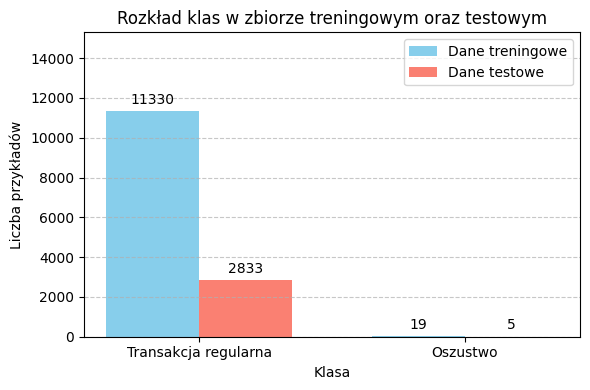

In [ ]:
# Podział danych na zbiór treningowy oraz zbiór testowy
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Class"], random_state=SEED)

if QUICK_MODE:
  _, full_test_df = train_test_split(full_df, test_size=0.2, stratify=full_df["Class"], random_state=SEED)


# Ograniczenie rozmiaru zbioru treningowego jeśli włączona jest flaga LIMIT_TRAINING_DATA_SIZE_MODE
if LIMIT_TRAINING_DATA_SIZE_MODE:
  train_df = stratified_sample(df, frac=LIMIT_TRAINING_DATA_SIZE_PERCENTAGE)

train_test_data_split = DataSplit(train_df.drop(columns=["Class"]), test_df.drop(columns=["Class"]),
                                  train_df["Class"], test_df["Class"])
plot_class_distribution(train_test_data_split, "Rozkład klas w zbiorze treningowym oraz testowym")

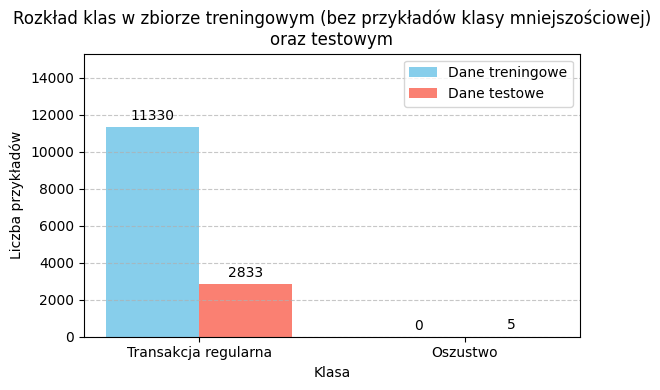

In [ ]:
def filter_df(df, class_label=Transaction.VALID_TRANSACTION.value):
    """
    Filtruje ramkę danych, pozostawiając tylko przykłady ustalonej klasy.

    Parametry:
        df: ramka danych zawierająca cechy i etykiety
        class_label: etykieta oznaczająca klasę, której egzemplarze mają pozostać

    Zwraca:
        Przefiltrowana ramka z samymi przykładami żądanej klasy
    """
    filtered_df = df[df["Class"] == class_label].copy()
    return filtered_df

# Odfiltrowane dane treningowe dla niektórych metod nienadzorowanych:
# chcemy trenować tylko na egzemplarzach klasy większościowej
filtered_train_df = filter_df(train_df)
filtered_train_test_data_split = DataSplit(filtered_train_df.drop(columns=["Class"]), test_df.drop(columns=["Class"]),
                                  filtered_train_df["Class"], test_df["Class"])
plot_class_distribution(filtered_train_test_data_split, "Rozkład klas w zbiorze treningowym (bez przykładów klasy mniejszościowej)\noraz testowym")



In [ ]:
# Przygotowanie podziałów danych na różne przypadki z uwględnieniem metod samplingu oraz k - krotnej walidacji
standard_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                     sampling_method=SamplingMethod.NONE)
undersampling_50_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.UNDER, sampling_strategy=0.5)
undersampling_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.UNDER, sampling_strategy=1.0)
oversampling_50_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.OVER, sampling_strategy=0.5)
oversampling_data_splits = prepare_train_test_data_splits(data=train_df, use_cv=True, k=CV_FOLDS_COUNT,
                                                             sampling_method=SamplingMethod.OVER, sampling_strategy=1.0)

# Do weryfikacji tylko
#plot_class_distribution(standard_data_splits, "Rozkład klas bez samplingu")
#plot_class_distribution(undersampling_50_data_splits, "Rozkład klas po undersamplingu (50%)")
#plot_class_distribution(undersampling_data_splits, "Rozkład klas po undersamplingu")
#plot_class_distribution(oversampling_50_data_splits, "Rozkład klas po oversamplingu (50%)")
#plot_class_distribution(oversampling_data_splits, "Rozkład klas po oversamplingu")

# Miary jakości

Do oceny jakości modelów wybrano następujące miary jakości:
- **AUC** - pole pod krzywą wykresu precyzja-recall - główna miara jakości
- **average precision** - średnia precyzja przy różnych progach klasyfikacji, również oparta na obszarze pod krzywą precyzja-odzysk - główna miara jakości
- **odzysk (recall)** - współczynnik pokazujący jaki odsetek oszustw został wykryty przez model wśród wszystkich transakcji-oszustw
- pre**cyzja (precision)** - jaki odsetek wykrytych transakcji-oszustw było faktycznie oszustwem - miara pomocnicza.
- **wskaźnik F1** - średnia harmoniczna precyzji i odzysku - pokazuje balans pomiędzy tymi dwoma wskaźnikami - miara pomocnicza


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    auc
)

def map_y_pred_for_unsupervised_methods(y_pred):
  return np.where(y_pred == UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL, Transaction.FRAUD.value, Transaction.VALID_TRANSACTION.value)

def evaluate_model(model, x_test, y_test, predict_positive_class_label=Transaction.FRAUD.value):
    """
    Ocena jakości modelu: precision, recall, F1 score, krzywa PR, average precision i interpolowana wartość AUC PR.
    Wyświetla tabelę z wynikami i wykres krzywej PR.

    Parametry:
    - model: wytrenowany model
    - x_test, y_test: dane testowe
    - predict_positive_class_label - określa etykietę klasy pozytywnej, która będzie zwracana przez predykcję

    Zwraca:
    - Słownik metrykami modelu
    """

    # Predykcja
    y_pred = model.predict(x_test)
    if hasattr(model, "predict_proba"):
        fraud_idx = list(model.classes_).index(predict_positive_class_label)
        y_scores = model.predict_proba(x_test)[:, fraud_idx]
    else:
        y_scores = model.decision_function(x_test)

    if predict_positive_class_label == UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL:
      y_pred = map_y_pred_for_unsupervised_methods(y_pred)

    # Podstawowe metryki
    recall = recall_score(y_test, y_pred, pos_label=Transaction.FRAUD.value)
    precision = precision_score(y_test, y_pred, pos_label=Transaction.FRAUD.value)
    f1 = f1_score(y_test, y_pred, pos_label=Transaction.FRAUD.value)

    # Wyznaczenie krzywej PR i metryk z nią związanych
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores, pos_label=Transaction.FRAUD.value)
    avg_precision = average_precision_score(y_test, y_scores, pos_label=Transaction.FRAUD.value)
    interpolated_auc = auc(recall_vals, precision_vals)

    # Tabelka metryk
    results_df = pd.DataFrame({
        "Precision": [precision],
        "Recall": [recall],
        "F1-Score": [f1],
        "Avg. Precision": [avg_precision],
        "AUC PR (interpolowane)": [interpolated_auc]
    })

    print("\nOcena jakości modelu:")
    print(results_df.head(1))

    return dict(precision=precision,
                recall=recall,
                f1=f1,
                avg_precision=avg_precision,
                interpolated_auc=interpolated_auc,
                precision_vals=precision_vals,
                recall_vals=recall_vals)


# Badania wybranych metod do detekcji anomalii

Dla wybranych algorytmów ustanowiono jednolity proces badawczy, który opisano poniżej:
1. Wstępnie przetworzone dane losowo podzielono na zbiór testowy (20% całości) i treningowy (80% całości)
2. Zbiór treningowy podzielono na 5 podzbiorów - do wykorzystania dla walidacji krzyżowej.
3. Dla każdego testowanego algorytmu wyszukano zestaw najlepszych parametrów
  1. Wybrano zestaw parametrów wraz z lista wartości do przetestowania
  2. Wybrano metody i strategie samplingu do przetestowania (strategia - docelowy stosunek rekordów klasy mniejszościowej do większościowej)
  3. Dla każdej wartości parametru, wypróbowano każdą z ustalonych wcześniej metod próbkowania.
  4. Dla pojedynczego testu, wytrenowano model 5 razy, za każdym razem wykorzystując 4 części podzbioru walidacji krzyżowej do treningu, a pozostałą 1 część jako zbiór testowy. Zbiory przekształcono wcześniej z użyciem undersamplingu lub oversamplingu (lub brak przekształcenia).
  5. Jako ostateczną wartość poszczególnych miar jakości dla pojedynczego testu obliczano średnią arytmetyczną uzyskanych wartości z 5 modeli wytrenowanych w pojedynczym procesie walidacji krzyżowej.
4. Na podstawie wyników, wybrano najlepszy zestaw parametrów.
5. Wytrenowano ostateczny model i wyliczono jego miary jakości, jako zbiór testowy wykorzystano oddzielony wcześniej zestaw danych w rozmiarze 20% zbioru początkowego. Zbior testowy nie był wykorzystywany w procesie poszukiwania parametrów.

In [ ]:
from dataclasses import dataclass, field
from typing import List
from datetime import datetime

@dataclass
class ParameterToTest:
    name: str
    values: List
    required_params: dict = field(default_factory = lambda: {})

@dataclass
class SamplingMethodToTest:
    method: SamplingMethod
    sampling_strategy: float
    data_splits: List[DataSplit]


def params_tune(params_to_test: List[ParameterToTest], sampling_methods_to_test: List[SamplingMethodToTest],
                build_model_function, model_name, seed=SEED, predict_positive_class_label=Transaction.FRAUD.value,
                special_stop_case=None, model_specific_params={}):
    all_results = []

    for param in params_to_test:
        for sampling_method in sampling_methods_to_test:
            for param_value in param.values:
                # TODO: Add more parameters if needed
                if special_stop_case and special_stop_case(param.name, sampling_method):
                    continue

                precision_list, recall_list, f1_list, avg_precision_list, interpolated_auc_list = [], [], [], [], []
                for fold_id, split in enumerate(sampling_method.data_splits, 1):
                    params = model_specific_params.copy()
                    if param.required_params:
                      params.update(param.required_params)
                    params[param.name] = param_value
                    model = build_model_function(**params)
                    print(
                        f"({datetime.now().strftime('%H:%M:%S')}) Fold {fold_id}. Main param: {param.name}={param_value}. All params: {params}.\nSampling method {sampling_method.method}, sampling strategy {sampling_method.sampling_strategy}. ")

                    if predict_positive_class_label == UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL:
                      model.fit(split.x_train)
                    else:
                      model.fit(split.x_train, split.y_train)

                    metrics_df = evaluate_model(
                        model,
                        split.x_test,
                        split.y_test,
                        predict_positive_class_label=predict_positive_class_label
                    )
                    precision_list.append(metrics_df["precision"])
                    recall_list.append(metrics_df["recall"])
                    f1_list.append(metrics_df["f1"])
                    avg_precision_list.append(metrics_df["avg_precision"])
                    interpolated_auc_list.append(metrics_df["interpolated_auc"])

                # Uśrednianie
                all_results.append(
                    dict(sampling=sampling_method.method.name,
                        sampling_strategy=sampling_method.sampling_strategy,
                        param=param.name,
                        value=param_value,
                        mean_precision=np.mean(precision_list),
                        mean_recall=np.mean(recall_list),
                        mean_f1=np.mean(f1_list),
                        mean_avg_precision=np.mean(avg_precision_list),
                        mean_interpolated_auc=np.mean(interpolated_auc_list)
                        # TODO: Opisac dlaczego ddof=1
                        # std_avg_precision=np.std(avg_precision_list, ddof=1),
                    )
                )

    results_df = pd.DataFrame(all_results)
    results_df.to_csv(f"results-{model_name}.csv", sep='\t')

    return results_df


In [ ]:
def train_model(train_df: pd.DataFrame, test_df: pd.DataFrame, best_params, build_model_function, model_name,
            sampling_method: SamplingMethod, sampling_strategy: float = 1.0,
            unsupervised_method=False, seed=SEED):
  x_train = train_df.drop(columns=["Class"])
  y_train = train_df["Class"]

  x_test = test_df.drop(columns=["Class"])
  y_test = test_df["Class"]

  sampler = get_sampler(sampling_method, sampling_strategy, seed)
  if sampler:
      x_train, y_train = sampler.fit_resample(x_train, y_train)

  model = build_model_function(**best_params)

  if unsupervised_method:
    model.fit(x_train)
  else:
    model.fit(x_train, y_train)

  joblib.dump(model, f"{model_name}.joblib")

  return model

In [ ]:
import joblib
import os

def train_and_evaluate_best_model(train_df: pd.DataFrame, test_df: pd.DataFrame, best_params, build_model_function,
                                  model_name, runtime_model_file_path, sampling_method: SamplingMethod,
                                  sampling_strategy: float = 1.0, unsupervised_method=False):
  if (QUICK_MODE and os.path.exists(runtime_model_file_path)):
    model = joblib.load(runtime_model_file_path)
  else:
    model = train_model(train_df, test_df, best_params, build_model_function, model_name,
                        sampling_method, sampling_strategy, unsupervised_method)

  x_test = test_df.drop(columns=["Class"])
  y_test = test_df["Class"]

  predict_positive_class_label = UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL if unsupervised_method else Transaction.FRAUD.value

  return evaluate_model(model, x_test, y_test, predict_positive_class_label=predict_positive_class_label)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def add_values_labes(plt):
  ax = plt.gca()
  for container in ax.containers:
      for bar in container:
          height = bar.get_height()
          x = bar.get_x()
          width = bar.get_width()
          ax.text(
              x + width * 0.05,  # lekko na lewo/prawo
              height + 0.002,    # delikatnie nad słupkiem
              f"{height:.3f}",
              ha='left',         # wyrównanie do lewej
              va='bottom',
              fontsize=8,
              rotation=0
          )

def plot_metric_by_param(results_df, param_name: str, metric_name: str, hue: str = None, title: str = None):
    if results_df is None:
      print(f"Brak danych z wynikami")
      return

    # Filtrowanie tylko dla danego parametru
    results_df_filtered = results_df[results_df["param"] == param_name].copy()

    if results_df_filtered.empty:
        print(f"Brak danych dla parametru: {param_name}")
        return

    # Tworzymy wykres
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=results_df_filtered,
        x="value",
        y=metric_name,
        hue=hue if hue else "value",
        palette="Set2",
        legend=True if hue else False
    )

    # Na razie wyłączone, bo gorzej jednak to wygląda
    # Dodaj wartości nad słupkami
    # add_values_labes(plt)

    plt.title(title or f"{metric_name} vs {param_name}", fontsize=14)
    plt.xlabel(f"Wartości parametru: {param_name}")
    plt.ylabel(metric_name)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_metric_groups_for_param(results_df, param_name: str, metric_names: list[str], title: str = None):
    if results_df is None:
      print(f"Brak danych z wynikami")
      return

    # Filtrowanie tylko dla danego parametru
    results_df_filtered = results_df[results_df["param"] == param_name].copy()

    if results_df_filtered.empty:
        print(f"Brak danych dla parametru: {param_name}")
        return

    # Tworzenie "długiego" DataFrame do rysowania
    results_df_melted = results_df_filtered.melt(
        id_vars=["value"],
        value_vars=metric_names,
        var_name="metric",
        value_name="score"
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=results_df_melted,
        x="value",
        y="score",
        hue="metric",
        palette="Set2",
    )

    # Na razie wyłączone, bo gorzej jednak to wygląda
    # Dodaj wartości nad słupkami
    # add_values_labes(plt)

    plt.title(title or f"Porównanie metryk dla parametru: {param_name}", fontsize=14)
    plt.xlabel(f"Wartości parametru: {param_name}")
    plt.ylabel("Wartość metryki")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(
        title="Metryka",
        bbox_to_anchor=(1.02, 1),  # x=102% szerokości, y=100% wysokości
        loc='upper left',
        borderaxespad=0
    )
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Zostaw miejsce po prawej stronie
    plt.show()

def plot_metric_groups_for_sampling(results_df, metric_names: list[str], title: str = None):
    if results_df is None:
      print(f"Brak danych z wynikami")
      return

    # Upewnij się, że sampling i strategy to stringi
    results_df_copy = results_df.copy()
    results_df_copy["sampling"] = results_df_copy["sampling"].astype(str)
    results_df_copy["sampling_strategy"] = results_df_copy["sampling_strategy"].astype(str)

    # Stwórz kolumnę grupującą
    results_df_copy["sampling_group"] = results_df_copy.apply(
        lambda row: f"{row['sampling']}\nstrategy={row['sampling_strategy']}", axis=1
    )

    # Przekształć dane do formatu długiego
    results_df_melted = results_df_copy.melt(
        id_vars=["sampling_group"],
        value_vars=metric_names,
        var_name="metric",
        value_name="score"
    )

    # Tworzymy wykres
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=results_df_melted,
        x="sampling_group",
        y="score",
        hue="metric",
        palette="Set2",
    )

    # Na razie wyłączone, bo gorzej jednak to wygląda
    # Dodaj wartości nad słupkami
    # add_values_labes(plt)

    plt.title(title or "Porównanie metryk dla różnych konfiguracji samplingu", fontsize=14)
    plt.xlabel("Konfiguracja: rodzaj metody samplingu + zastosowana strategia")
    plt.ylabel("Wartość metryki")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend(
        title="Metryka",
        bbox_to_anchor=(1.02, 1),  # x=102% szerokości, y=100% wysokości
        loc='upper left',
        borderaxespad=0
    )
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Zostaw miejsce po prawej stronie
    plt.show()

def plot_metric_summary(
    metric_values: dict,
    metric_labels: list[str] = None,
    title: str = "Podsumowanie metryk jakości modelu"
):
    if metric_labels is None:
      metric_labels = ["precision", "recall", "f1", "avg_precision", "interpolated_auc"]

    # Mapowanie nazw metryk do czytelnych etykiet
    label_names_map = {
      "precision": "Precision",
      "recall": "Recall",
      "f1": "F1-score",
      "avg_precision": "Avg Precision",
      "interpolated_auc": "AUC PR (interpolowany)"
    }

    # Filtrowanie i przygotowanie danych
    selected_metrics = [metric_values[label] for label in metric_labels]
    selected_labels = [label_names_map.get(label, label) for label in metric_labels]

    df_plot = pd.DataFrame({
        "Metryka": selected_labels,
        "Wartość": selected_metrics
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df_plot,
        x="Metryka",
        y="Wartość",
        hue="Metryka",
        palette="Set2"
    )

    plt.title(title, fontsize=14)
    plt.ylim(0, 1.05)
    plt.ylabel("Wartość metryki")
    plt.xlabel("Metryka")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_pr_curve(recall_vals, precision_vals, avg_precision,
                  plot_title="Krzywa Precision-Recall"):
  # Wykres krzywej PR
  plt.figure(figsize=(6, 5))
  plt.plot(recall_vals, precision_vals, label=f"AP={avg_precision:.4f}", color='teal')
  plt.fill_between(recall_vals, precision_vals, alpha=0.1, color='teal')
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title(plot_title)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.legend()
  plt.tight_layout()
  plt.show()

## Metody nadzorowane

### Las losowy

In [ ]:
from sklearn.ensemble import RandomForestClassifier

if QUICK_MODE:
  random_forest_params_to_test = [
    ParameterToTest(name="n_estimators", values=[50, 300]),
    ParameterToTest(name="max_features", values=["sqrt", None]),
    ParameterToTest(name="class_weight", values=["balanced", "balanced_subsample", None]),
  ]

  random_forest_sampling_method_to_test = [
    SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
    SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
    SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
  ]
else:
  random_forest_params_to_test = [
        ParameterToTest(name="n_estimators", values=[50, 100, 200, 300]),
        ParameterToTest(name="max_features", values=["sqrt", "log2", 0.3, 0.5, None]),
        ParameterToTest(name="class_weight", values=["balanced", "balanced_subsample", None]),
    ]

  random_forest_sampling_method_to_test = [
        SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=0.5,
                             data_splits=undersampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=0.5,
                             data_splits=oversampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
    ]

def build_random_forest_model(**kwargs):
    return RandomForestClassifier(**kwargs)


def random_forest_special_stop_case(param_name: str, sampling_method: SamplingMethodToTest):
    is_class_weight_test = param_name == "class_weight"
    is_data_sampled = sampling_method.method != SamplingMethod.NONE

    # Jezeli dane sa samplowane, nie testujemy zadnych wartosci parametru "class_weight"
    if is_class_weight_test and is_data_sampled:
        print(f"Pomiń, ponieważ sampling method: {sampling_method.method} i param_name: {param_name} ")
        return True
    else:
        return False

model_specific_params = {
    "random_state": SEED,
    "n_jobs": -1}

results = params_tune(random_forest_params_to_test, sampling_methods_to_test=random_forest_sampling_method_to_test,
                      special_stop_case=random_forest_special_stop_case, build_model_function=build_random_forest_model,
                      model_specific_params=model_specific_params, model_name='random_forest')
results
print("Pełne wyniki (dla quick_mode=False)")

random_forest_results = pd.read_csv("Results/results-random_forest.csv",sep="\t", index_col=0)
random_forest_results.replace({np.nan: None}, inplace=True)
random_forest_results


(17:21:56) Fold 1. Main param: n_estimators=50. All params: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 50}.
Sampling method SamplingMethod.NONE, sampling strategy 0. 

Ocena jakości modelu:
   Precision  Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0        1.0     0.7  0.823529          0.9625                 0.96875
(17:21:57) Fold 2. Main param: n_estimators=50. All params: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 50}.
Sampling method SamplingMethod.NONE, sampling strategy 0. 

Ocena jakości modelu:
   Precision    Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0       0.75  0.333333  0.461538        0.385714                0.411162
(17:21:57) Fold 1. Main param: n_estimators=300. All params: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 300}.
Sampling method SamplingMethod.NONE, sampling strategy 0. 

Ocena jakości modelu:
   Precision  Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0        1.0     0.5  0.666667             1.

,sampling,sampling_strategy,param,value,mean_precision,mean_recall,mean_f1,mean_avg_precision,mean_interpolated_auc
0,NONE,0.0,n_estimators,50,0.949544,0.775053,0.850662,0.827127,0.836777
1,NONE,0.0,n_estimators,100,0.942264,0.775088,0.848139,0.834435,0.840157
2,NONE,0.0,n_estimators,200,0.939346,0.775088,0.847267,0.838509,0.842270
3,NONE,0.0,n_estimators,300,0.934282,0.777719,0.846376,0.839592,0.842099
4,UNDER,0.5,n_estimators,50,0.156230,0.873018,0.262924,0.751360,0.786015
5,UNDER,0.5,n_estimators,100,0.155396,0.873018,0.261765,0.757609,0.785819
6,UNDER,0.5,n_estimators,200,0.156405,0.878281,0.263903,0.753718,0.779550
7,UNDER,0.5,n_estimators,300,0.155190,0.875649,0.261910,0.753443,0.776007
8,UNDER,1.0,n_estimators,50,0.066562,0.894175,0.123673,0.733076,0.773860
9,UNDER,1.0,n_estimators,100,0.066395,0.891544,0.123482,0.755802,0.783619


In [ ]:


def get_cmap_iterator(n, color_name):
    cmap = matplotlib.colormaps[color_name].resampled(n)
    list = [matplotlib.colors.to_hex(cmap(i)) for i in range(n)]
    return iter(reversed(list))


def draw_n_estimators_plot(results: pd.DataFrame):
    overs = results[(results["sampling"] == "OVER") & (results["param"] == "n_estimators")]

    plt.figure()

    for val, group in overs.groupby("sampling_strategy"):
        plt.plot(group["value"], group["mean_avg_precision"], label=f"Sampling strategy = {val}", marker="o")

    plt.ylim(bottom=0.76, top=0.86)
    plt.xlabel("n_estimators - liczba drzew")
    plt.ylabel("Avg Precision Score - średnia z 5 walidacji krzyżowych\n")
    plt.title("Avg Precision Score vs. n_estimators dla SMOTE oversampling")
    plt.tight_layout()
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


def draw_recall_precision_plot(results: pd.DataFrame):
    filtered_results = results[(results["value"] == "100") | (results["param"] == "class_weight")]

    cmaps = [get_cmap_iterator(4, 'Purples'),
             get_cmap_iterator(5, 'Oranges'), get_cmap_iterator(4, 'Greens')]

    for sampling_method, group_sm in filtered_results.groupby("sampling"):
        sampling_strategy = SamplingMethod.from_string(sampling_method)
        if sampling_strategy == SamplingMethod.NONE:
            for value, group_val in group_sm[group_sm["param"] == "class_weight"].groupby("value", dropna=False):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_val["mean_recall"], group_val["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (class_weight={value})", color=color, alpha=0.9)
        else:
            for strategy, group_strat in group_sm.groupby("sampling_strategy"):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_strat["mean_recall"], group_strat["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (strategy={strategy})", color=color)

    ax = plt.gca()
    plt.xlabel("Średni odzysk")
    plt.ylabel("Średnia precyzja")
    plt.title("Porównanie precyzji i odzysku na podstawie metody próbkowania\n(pozostałe parametry domyślne)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc="lower left", prop={'size': 8})
    plt.figure(figsize=(8, 6))
    plt.show()



def draw_best_f1_plot(results: pd.DataFrame):
    names = []
    values = []
    best_f1_ids = results.groupby("sampling")["mean_f1"].idxmax()
    for id in best_f1_ids:
        entry = results.iloc[id]
        names.append(
            f"{SamplingMethod.from_string(entry['sampling']).to_string()}\nsampling_strategy: {entry['sampling_strategy']}")
        values.append(entry["mean_f1"])

    plt.bar(names, values)
    plt.title('Najwyższy współczynnik F1 uzyskany dla\n poszczególnych strategii próbkowania')
    plt.xlabel("Strategia")
    plt.ylabel('F1 - średnia z 5 walidacji krzyżowych')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.figure(figsize=(8, 6))
    plt.show()


#### Porównanie precyzji i odzysku


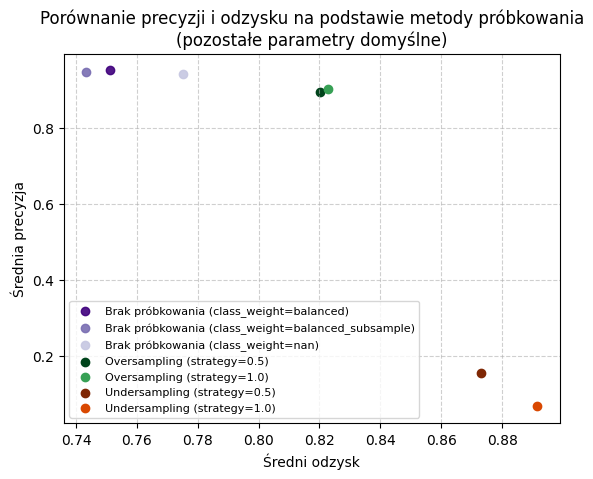

<Figure size 800x600 with 0 Axes>

In [ ]:
draw_recall_precision_plot(random_forest_results)

Na wykresie pokazano 3 metody samplingu:
- brak próbkowania
- undersampling
- oversampling

dla domyślnych parametrów modelu:

- `n_estimators = 100`
- `max_features = 'sqrt'`
- `class_weight = None`

z różnymi wartościami *strategy*, gdzie:
- *1* = klasy całkowicie zbilansowane
- *0.5* = klasa większościowa pozostaje w większości, liczba rekordów klasy mniejszościowej jest o 50% mniejsza.

Na wykresie widać, że najlepszy odzysk (*~0.89*) uzyskał undersampling. Jest to
jednak obarczone bardzo niską precyzją (poniżej *0.2*). Najlepszą równowagę między precyzją a odzyskiem uzyskaliśmy wykorzystując **oversampling** z wartością **strategy=0.1**.

#### F1 dla poszczególnych strategii próbkowania

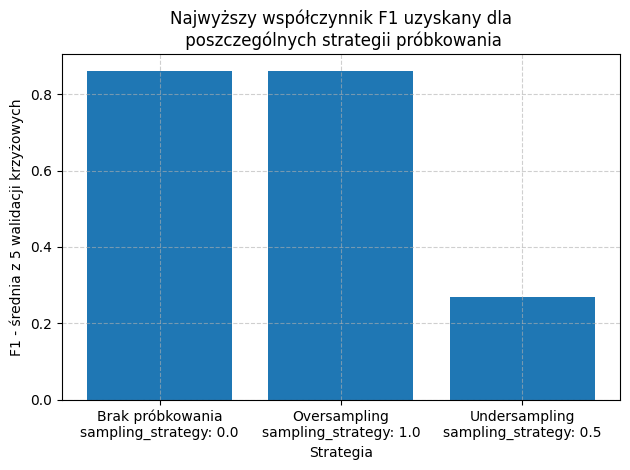

<Figure size 800x600 with 0 Axes>

In [ ]:
draw_best_f1_plot(random_forest_results)

Dla poszczególnych strategii wyszczególniono najwyższą wartość współczynnika F1 dla dowolnych wartości pozostałych parametrów. Tu również widać, że undersampling uzyskał najsłabsze wyniki.

#### Wpływ liczby drzew


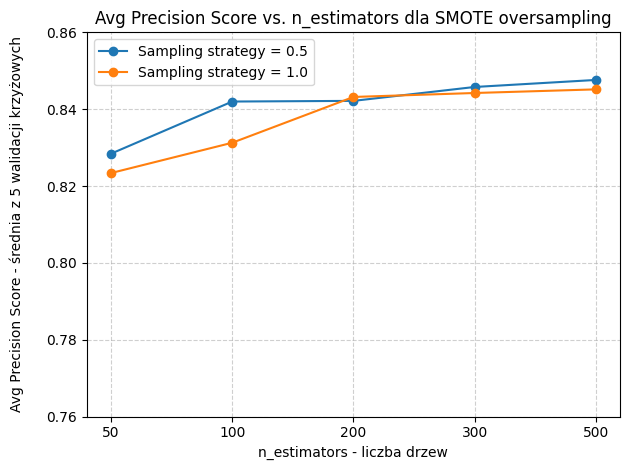

In [ ]:
draw_n_estimators_plot(random_forest_results)

Dla nadpróbkowania, które wykazuje najlepsze wyniki w testach, sprawdzono wpływ parametru `n_estimators` - czyli liczby drzew, na *Average Precision Score*. Okazuje się, że krzywa zaczyna "wypłaszczać się" w okolicach wartości parametru `n_estimators=200`. Dla wartości `500` można było dalej uzyskać nieznacznie lepszy model przy wydłużonym, jednak nadal akceptowalnym czasie trwania treningu.

#### Wybór najlepszych parametrów

In [ ]:
random_forest_results.sort_values(by=["mean_interpolated_auc"], ascending=False).head(5)

,sampling,sampling_strategy,param,value,mean_precision,mean_recall,mean_f1,mean_avg_precision,mean_interpolated_auc
51,OVER,0.5,n_estimators,500,0.900635,0.822702,0.858662,0.847607,0.848472
15,OVER,0.5,n_estimators,300,0.906055,0.820070,0.859447,0.845778,0.847173
36,OVER,0.5,max_features,log2,0.905355,0.820105,0.859643,0.842346,0.846769
13,OVER,0.5,n_estimators,100,0.893616,0.820070,0.853619,0.841990,0.846671
35,OVER,0.5,max_features,sqrt,0.893616,0.820070,0.853619,0.841990,0.846671


Najwyższą średnią `AUC=0.848472` dla wykresu precision-recall uzyskał zestaw parametrów (Oversampling, `strategy=0.5`, `n_estimators=500`, `max_features=sqrt`, `class_weight=None`). Oprócz tego wysoki współczynnik `F1` (`~0.859`) i `precision` (`~0.90`).
Dla uzyskanych parametrów przechodzimy do treningu modelu na pełnym zbiorze danych i testów na zbiorze testowym.


Ocena jakości modelu:
   Precision  Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0   0.833333     1.0  0.909091             1.0                     1.0


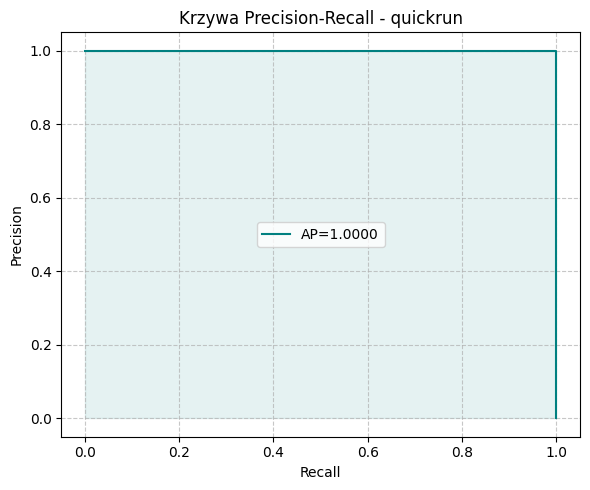


Ocena jakości modelu:
   Precision    Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0   0.911392  0.757895  0.827586        0.824574                0.825025


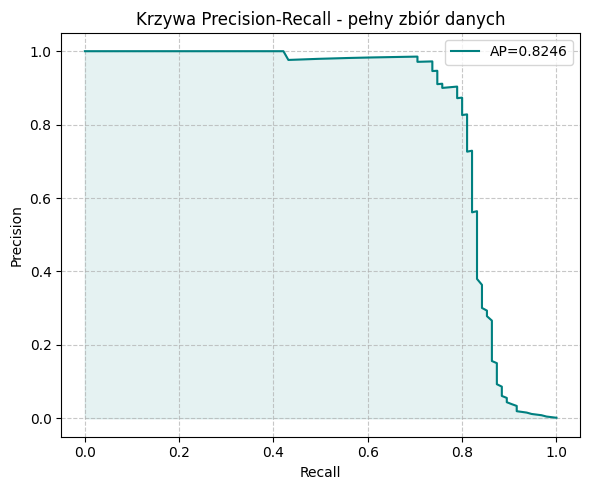

,Tryb,Precision,Recall,F1-Score,Avg. Precision,AUC PR (interpolowane)
0,quickrun,0.833333,1.000000,0.909091,1.000000,1.000000
1,full,0.911392,0.757895,0.827586,0.824574,0.825025


In [ ]:
import joblib

best_params = {
    "random_state": SEED,
    "n_jobs": -1,
    "n_estimators": 500,
    "max_features": "sqrt",
    "class_weight": None,
}

model = train_model(train_df, test_df,best_params,build_random_forest_model, "random_forest", SamplingMethod.OVER, sampling_strategy=0.5)

x_test = test_df.drop(columns=["Class"])
y_test = test_df["Class"]

if QUICK_MODE:
  x_test_full = full_test_df.drop(columns=["Class"])
  y_test_full = full_test_df["Class"]
  results_quick = evaluate_model(model, x_test, y_test)
  plot_pr_curve(recall_vals=results_quick["recall_vals"], precision_vals=results_quick["precision_vals"],
                avg_precision=results_quick["avg_precision"], plot_title="Krzywa Precision-Recall - quickrun")

  # Pełen model wytrenowany wcześniej z tymi samymi parametram
  full_model = joblib.load("Results/random_forest.joblib")
  results = evaluate_model(full_model, x_test_full, y_test_full)
  plot_pr_curve(recall_vals=results["recall_vals"], precision_vals=results["precision_vals"],
                avg_precision=results["avg_precision"], plot_title="Krzywa Precision-Recall - pełny zbiór danych")

  results_df = pd.DataFrame({
      "Tryb": ["quickrun", "full"],
      "Precision": [results_quick["precision"],results["precision"]],
      "Recall": [results_quick['recall'],results['recall']],
      "F1-Score": [results_quick['f1'],results['f1']],
      "Avg. Precision": [results_quick['avg_precision'],results['avg_precision']],
      "AUC PR (interpolowane)": [results_quick['interpolated_auc'],results['interpolated_auc']],
  })
  display(results_df)
else:
    results = evaluate_model(model, x_test, y_test)
    plot_pr_curve(recall_vals=results["recall_vals"], precision_vals=results["precision_vals"],
                  avg_precision=results["avg_precision"], plot_title="Krzywa Precision-Recall - pełny zbiór danych")
    results

best_results_df = pd.DataFrame({
      "Model": ["Random Forest"],
      "Precision": [results["precision"]],
      "Recall": [results['recall']],
      "F1-Score": [results['f1']],
      "Avg. Precision": [results['avg_precision']],
      "AUC PR (interpolowane)": [results['interpolated_auc']]
      })

Powyżej przedstawiono ostateczne wyniki modelu dla najlepszych parametrów - do testów uzyto 20% zbioru ktory nie był wykorzystywany w trakcie procesu trenowania i tuningu parametrów.


### Drzewo decyzyjne







In [ ]:
from sklearn.tree import DecisionTreeClassifier


if QUICK_MODE:
  decision_tree_params_to_test = [
      ParameterToTest(name="max_depth", values=[None, 10]),
      ParameterToTest(name="class_weight", values=["balanced"]),
  ]

  decision_tree_sampling_method_to_test = [
      SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
      SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
      SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits)]

else:
  decision_tree_params_to_test = [
      ParameterToTest(name="max_depth", values=[None, 3, 5, 10, 15, 20, 30]),
      ParameterToTest(name="class_weight", values=[None, "balanced"]),
  ]

  decision_tree_sampling_method_to_test = [
      SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
      SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=0.5,
                            data_splits=undersampling_50_data_splits),
      SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
      SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=0.5,
                            data_splits=oversampling_50_data_splits),
      SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits)]

def build_decision_tree_classifier(**kwargs):
    return DecisionTreeClassifier(**kwargs)

def decision_tree_classifier(param_name: str, sampling_method: SamplingMethodToTest):
    is_class_weight_test = param_name == "class_weight"
    is_data_sampled = sampling_method.method != SamplingMethod.NONE

    # Jezeli dane sa samplowane, nie testujemy zadnych wartosci parametru "class_weight"
    if is_class_weight_test and is_data_sampled:
        print(f"Pomiń, ponieważ sampling method: {sampling_method.method} i param_name: {param_name} ")
        return True
    else:
        return False

model_specific_params = {
    "random_state": SEED
    }

results = params_tune(decision_tree_params_to_test, sampling_methods_to_test=decision_tree_sampling_method_to_test,
                      special_stop_case=decision_tree_classifier,
                      build_model_function=build_decision_tree_classifier,
                      model_specific_params=model_specific_params, model_name='decision_tree')
print(results)
print("\nPełne wyniki (dla quick_mode=False)\n")
decision_tree_results = pd.read_csv("Results/results-decision_tree.csv",sep="\t", index_col=0)
decision_tree_results



(17:23:40) Fold 1. Main param: max_depth=None. All params: {'random_state': 42, 'max_depth': None}.
Sampling method SamplingMethod.NONE, sampling strategy 0. 

Ocena jakości modelu:
   Precision  Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0        0.6     0.9      0.72        0.540176                0.750088
(17:23:40) Fold 2. Main param: max_depth=None. All params: {'random_state': 42, 'max_depth': None}.
Sampling method SamplingMethod.NONE, sampling strategy 0. 

Ocena jakości modelu:
   Precision    Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0       0.75  0.333333  0.461538        0.251057                0.542195
(17:23:40) Fold 1. Main param: max_depth=10. All params: {'random_state': 42, 'max_depth': 10}.
Sampling method SamplingMethod.NONE, sampling strategy 0. 

Ocena jakości modelu:
   Precision  Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0        0.6     0.9      0.72        0.540176                0.750088
(17:23:40) Fold 2. Main para

,sampling,sampling_strategy,param,value,mean_precision,mean_recall,mean_f1,mean_avg_precision,mean_interpolated_auc
0,NONE,0.0,max_depth,NaN,0.757831,0.753684,0.754090,0.570973,0.755962
1,NONE,0.0,max_depth,3,0.846747,0.732667,0.783056,0.706538,0.803736
2,NONE,0.0,max_depth,5,0.906584,0.764596,0.829230,0.740168,0.784761
3,NONE,0.0,max_depth,10,0.873200,0.753684,0.807415,0.661321,0.714071
4,NONE,0.0,max_depth,15,0.788965,0.753684,0.769388,0.595985,0.682359
5,NONE,0.0,max_depth,20,0.763640,0.753684,0.757029,0.576765,0.705088
6,NONE,0.0,max_depth,30,0.757831,0.753684,0.754090,0.570973,0.755962
7,UNDER,0.5,max_depth,NaN,0.025423,0.878351,0.049376,0.022529,0.451988
8,UNDER,0.5,max_depth,3,0.130750,0.849158,0.217720,0.192558,0.431512
9,UNDER,0.5,max_depth,5,0.066925,0.854526,0.122159,0.060430,0.372662


In [ ]:
def plot_max_depth_vs_ap(results_df):
    max_depth_results = results_df[results_df['param'] == 'max_depth'].copy()

    max_depth_results['sampling_label'] = max_depth_results.apply(
        lambda row: f"{SamplingMethod.from_string(row['sampling']).to_string()}\nStrategy: {row['sampling_strategy']}",
        axis=1
    )
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=max_depth_results,
        x='value',
        y='mean_avg_precision',
        hue='sampling_label',
        marker='o'
    )

    plt.title('Average Precision Score vs. max_depth dla różnych metod próbkowania')
    plt.xlabel('max_depth')
    plt.ylabel('Średnia Average Precision')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Metoda Samplingu', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Zostaw miejsce na legendę
    plt.show()


#### Wpływ parametru `max_depth`

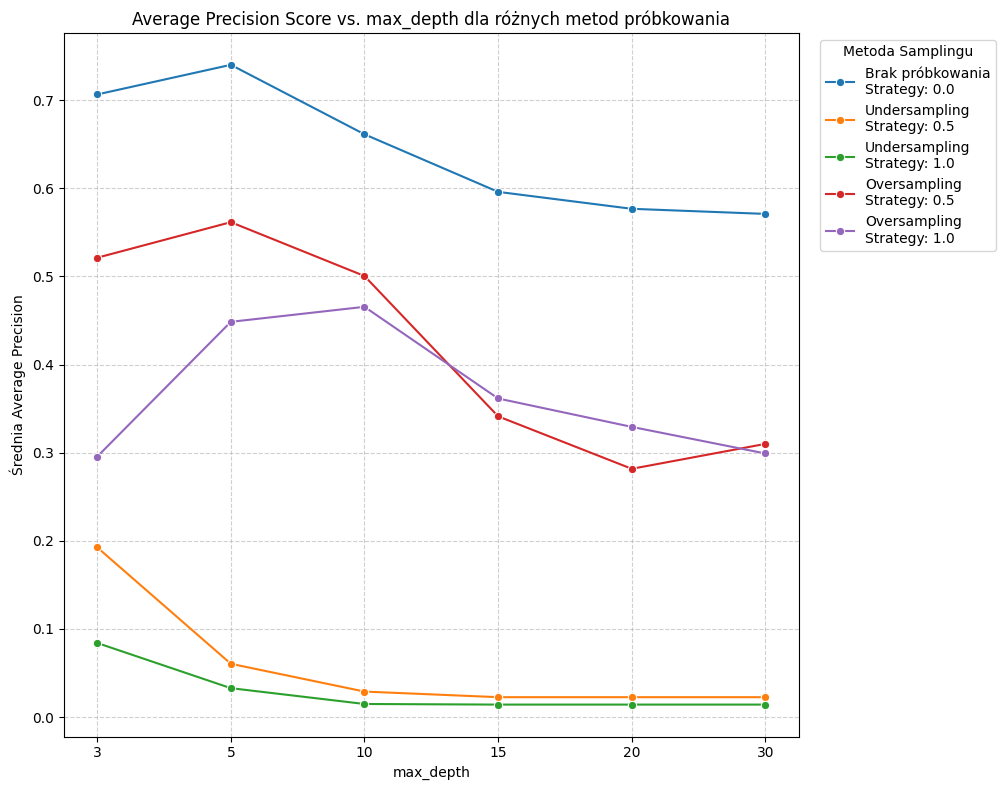

In [ ]:
plot_max_depth_vs_ap(decision_tree_results)

Na wykresie przedstawiono wpływ parametru `max_depth` - czyli maksymalna głębokość drzewa - na uzyskany wynik parametru Average Precision Score dla różnych metod próbkowania.

Widać tutaj, że dla drzewa decyzyjnego, zastosowanie samplingu nie poprawia jakości modelu. Najlepszy wynik uzyskano dla braku próbkowania i maksymalnej głębokości wynoszącej `5`.

#### Porównanie precyzji i odzysku

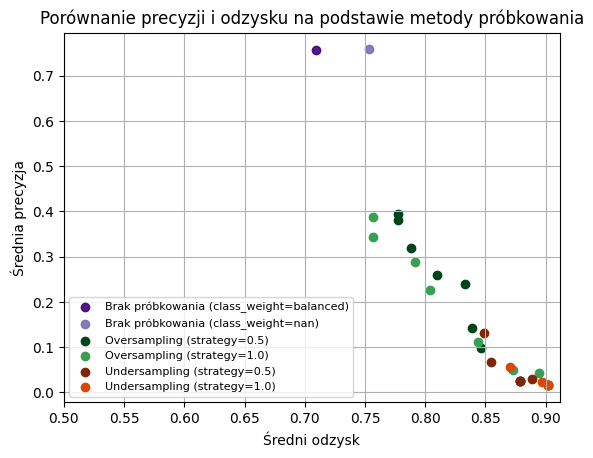

<Figure size 800x600 with 0 Axes>

In [ ]:
def draw_recall_precision_plot(results: pd.DataFrame):

    cmaps = [get_cmap_iterator(4, 'Purples'),
             get_cmap_iterator(5, 'Oranges'), get_cmap_iterator(4, 'Greens')]

    for sampling_method, group_sm in results.groupby("sampling"):
        sampling_strategy = SamplingMethod.from_string(sampling_method)
        if sampling_strategy == SamplingMethod.NONE:
            for value, group_val in group_sm[group_sm["param"] == "class_weight"].groupby("value", dropna=False):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_val["mean_recall"], group_val["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (class_weight={value})", color=color, alpha=0.9)
        else:
            for strategy, group_strat in group_sm.groupby("sampling_strategy"):
                cmap = cmaps[sampling_strategy.value]
                color = next(cmap)
                plt.scatter(group_strat["mean_recall"], group_strat["mean_precision"],
                            label=f"{sampling_strategy.to_string()} (strategy={strategy})", color=color)

    ax = plt.gca()
    plt.xlabel("Średni odzysk")
    plt.ylabel("Średnia precyzja")
    plt.title("Porównanie precyzji i odzysku na podstawie metody próbkowania")
    plt.grid(True)
    plt.xlim(left = 0.5)
    plt.legend(loc="lower left", prop={'size': 8})
    plt.figure(figsize=(8, 6))
    plt.show()

draw_recall_precision_plot(decision_tree_results)


Na wykresie porównano precyzję i odzysk dla różnych wartości `max_depth` z podziałem na metody próbkowania.

Najwyższy odzysk można uzyskać stosując podpróbkowanie, jednak kosztem bardzo niskiej precyzji, poniżej (< `0.15`). W zależności od kosztów obsługi fałszywego alarmu oraz nie wykrycia transakcji-oszustwa, w modelu produkcyjnym można rozważyć nadpróbkowanie albo całkowitą rezygnację z próbkowania.

#### F1 dla poszczególnych strategii próbkowania

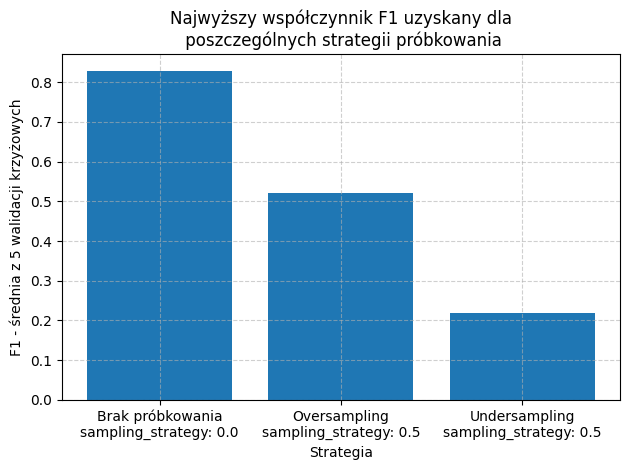

<Figure size 800x600 with 0 Axes>

In [ ]:
draw_best_f1_plot(decision_tree_results)

Dla poszczególnych strategii wyszczególniony najwyższą wartość współczynnika F1 dla dowolnych wartości pozostałych parametrów. Brak próbkowania wybija się z wynikiem > `0.8`

#### Wybór najlepszych parametrów

In [ ]:
decision_tree_results.sort_values(by=["mean_interpolated_auc"], ascending=False).head(5)

,sampling,sampling_strategy,param,value,mean_precision,mean_recall,mean_f1,mean_avg_precision,mean_interpolated_auc
1,NONE,0.0,max_depth,3,0.846747,0.732667,0.783056,0.706538,0.803736
2,NONE,0.0,max_depth,5,0.906584,0.764596,0.829230,0.740168,0.784761
0,NONE,0.0,max_depth,NaN,0.757831,0.753684,0.754090,0.570973,0.755962
35,NONE,0.0,class_weight,NaN,0.757831,0.753684,0.754090,0.570973,0.755962
6,NONE,0.0,max_depth,30,0.757831,0.753684,0.754090,0.570973,0.755962


Najwyższą średnią `AUC=0.803736` dla wykresu precision-recall uzyskano bez próbkowania, z parametrem `max_depth=3`. Na drugim miejscu, z wartością `max_depth=5`, wartość AUC jest nieznacznie niższa (`AUC=0.784761`), natomiast z uwagi na lepsze wartości precyzji, odzysku i współczynnika F1, uznano że jest to bardziej optymalne ustawienie.



Ocena jakości modelu:
   Precision  Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0        0.8     0.8       0.8        0.640352                0.730433


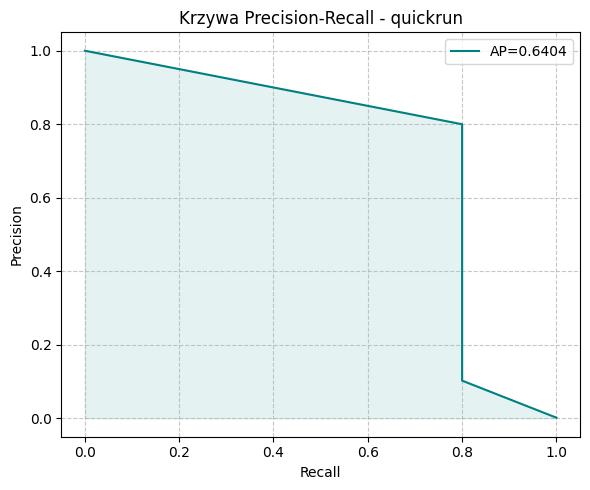


Ocena jakości modelu:
   Precision    Recall  F1-Score  Avg. Precision  AUC PR (interpolowane)
0   0.881579  0.705263  0.783626        0.641593                0.658603


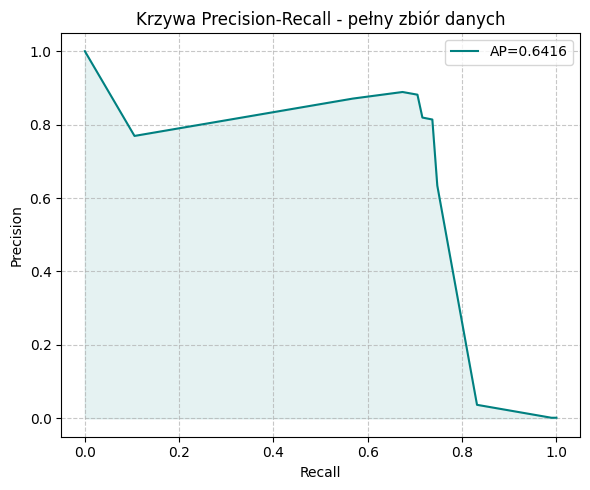

,Tryb,Precision,Recall,F1-Score,Avg. Precision,AUC PR (interpolowane)
0,quickrun,0.800000,0.800000,0.800000,0.640352,0.730433
1,full,0.881579,0.705263,0.783626,0.641593,0.658603


In [ ]:
import joblib
best_params = {
    "max_depth": 5,
    "class_weight": None
}


model = train_model(train_df, test_df,best_params,build_decision_tree_classifier,  "decision_tree", SamplingMethod.NONE)
x_test = test_df.drop(columns=["Class"])
y_test = test_df["Class"]

if QUICK_MODE:
  x_test_full = full_test_df.drop(columns=["Class"])
  y_test_full = full_test_df["Class"]
  results_quick = evaluate_model(model, x_test, y_test)
  plot_pr_curve(recall_vals=results_quick["recall_vals"], precision_vals=results_quick["precision_vals"],
                avg_precision=results_quick["avg_precision"], plot_title="Krzywa Precision-Recall - quickrun")

  # Pełen model wytrenowany wcześniej z tymi samymi parametram
  full_model = joblib.load("Results/decision_tree.joblib")
  results = evaluate_model(full_model, x_test_full, y_test_full)
  plot_pr_curve(recall_vals=results["recall_vals"], precision_vals=results["precision_vals"],
                avg_precision=results["avg_precision"], plot_title="Krzywa Precision-Recall - pełny zbiór danych")

  results_df = pd.DataFrame({
      "Tryb": ["quickrun", "full"],
      "Precision": [results_quick["precision"],results["precision"]],
      "Recall": [results_quick['recall'],results['recall']],
      "F1-Score": [results_quick['f1'],results['f1']],
      "Avg. Precision": [results_quick['avg_precision'],results['avg_precision']],
      "AUC PR (interpolowane)": [results_quick['interpolated_auc'],results['interpolated_auc']]
  })
  display(results_df)

else:
    results = evaluate_model(model, x_test, y_test)
    plot_pr_curve(recall_vals=results["recall_vals"], precision_vals=results["precision_vals"],
                  avg_precision=results["avg_precision"], plot_title="Krzywa Precision-Recall - pełny zbiór danych")
    display(results)


best_results_df = pd.concat([best_results_df,
                             pd.DataFrame([["Decision Tree", results["precision"], results['recall'],
                                            results['f1'], results['avg_precision'], results['interpolated_auc']]],
                                          columns=best_results_df.columns)],
                            ignore_index=True)

## Metody nienadzorowane

### One-Class SVM

Tutaj na razie wstępny wywołanie, żeby zobaczyć czy mniej więcej działa metoda do oceny jakości modelu.

In [ ]:
from sklearn.svm import OneClassSVM
def build_oc_svm_model_function(**kwargs):
    return OneClassSVM(**kwargs)

In [ ]:
import os

if QUICK_MODE:
  oc_svm_params_to_test = [
        ParameterToTest(name="kernel", values=['linear', 'rbf']),
        ParameterToTest(name="nu", values=[0.01, 0.1, 0.2]),
        ParameterToTest(name="gamma", values=['scale', 'auto'], required_params={"kernel": 'rbf'}),
    ]

  oc_svm_sampling_method_to_test = [
    SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
    SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
    SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
  ]
else:
  oc_svm_params_to_test = [
        ParameterToTest(name="kernel", values=['linear', 'rbf']),
        ParameterToTest(name="nu", values=[0.01, 0.05, 0.1, 0.2]),
        ParameterToTest(name="gamma", values=['scale', 'auto', 0.01, 0.1, 1.0], required_params={"kernel": 'rbf'}),
    ]

  oc_svm_sampling_method_to_test = [
        SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=0.5,
                             data_splits=undersampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=0.5,
                             data_splits=oversampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
    ]

# Domyślnie używamy rbf, nu=0.2 - kwestie wydajności
# 8192 MB rozmiar cache, domyślnie 200 MB, żeby było szybciej
# Także zwiększamy tolerancję, będą gorsze wyniki, ale szybciej
ocv_svm_model_specific_params = {
    "kernel": "rbf",
    "nu": 0.5,
    "cache_size": 8192,
    "tol": 0.1,
}

if (QUICK_MODE and os.path.exists(oc_svm_tune_results_tmp_file_path)):
  oc_svm_params_runtime_tune_results = pd.read_csv(oc_svm_tune_results_tmp_file_path, sep="\t", index_col=0)
else:
  oc_svm_params_runtime_tune_results = params_tune(oc_svm_params_to_test, sampling_methods_to_test=oc_svm_sampling_method_to_test,
                                         build_model_function=build_oc_svm_model_function, predict_positive_class_label=UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL,
                                         model_specific_params=ocv_svm_model_specific_params, model_name=oc_svm_model_name)
print(oc_svm_params_runtime_tune_results)

TODO: Opis - dane wcześniej wygenerowane

In [ ]:
if (LOAD_PARAMS_TUNE_RESULTS_FROM_MASTER_FILE and os.path.exists(oc_svm_tune_results_master_file_path)):
  oc_svm_params_full_tune_results = pd.read_csv(oc_svm_tune_results_master_file_path, sep="\t", index_col=0)
  print(oc_svm_params_full_tune_results)

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_param(oc_svm_params_runtime_tune_results, param_name="kernel", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_param(oc_svm_params_full_tune_results, param_name="kernel", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników


TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_param(oc_svm_params_runtime_tune_results, param_name="nu", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_param(oc_svm_params_full_tune_results, param_name="nu", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_param(oc_svm_params_runtime_tune_results, param_name="gamma", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_param(oc_svm_params_full_tune_results, param_name="gamma", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_sampling(oc_svm_params_runtime_tune_results, metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_sampling(oc_svm_params_full_tune_results, metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: Wstęp do budowania i ewaluacji modelu

In [ ]:
oc_svm_best_params = {
    "kernel": "rbf",
    "gamma": 1.0,
    "nu": 0.2,
    "cache_size": 8192,
}
oc_svm_sampling_method = SamplingMethod.NONE
oc_svm_sampling_strategy = 0.0

oc_svm_runtime_model_evaluation_result = train_and_evaluate_best_model(train_df, test_df, oc_svm_best_params,
                                                                       build_oc_svm_model_function,
                                                                       oc_svm_model_name, oc_svm_runtime_model_file_path,
                                                                       oc_svm_sampling_method, oc_svm_sampling_strategy,
                                                                       unsupervised_method=True)

TODO: Wstęp do budowania i ewaluacji modelu bez outlierów

In [ ]:
oc_svm_filtered_train_df_best_params = {
    "kernel": "rbf",
    "gamma": 1.0,
    "nu": 0.2,
    "cache_size": 8192,
}
oc_svm_filtered_train_df_sampling_method = SamplingMethod.NONE
oc_svm_filtered_train_df_sampling_strategy = 0.0

oc_svm_runtime_model_filtered_train_df_evaluation_result = train_and_evaluate_best_model(filtered_train_df,
                                                                      test_df,
                                                                      oc_svm_filtered_train_df_best_params,
                                                                      build_oc_svm_model_function,
                                                                      oc_svm_filtered_train_df_model_name,
                                                                      oc_svm_runtime_model_filtered_train_df_file_path,
                                                                      oc_svm_filtered_train_df_sampling_method,
                                                                      oc_svm_filtered_train_df_sampling_strategy,
                                                                      unsupervised_method=True)

TODO: Wstęp do załadowania pretrenowanego modelu i też jego ewaluacja

In [ ]:
if (LOAD_PRETRAINED_MODEL and os.path.exists(oc_svm_pretrained_model_file_path)):
  oc_svm_full_model = joblib.load(oc_svm_pretrained_model_file_path)

  x_test = test_df.drop(columns=["Class"])
  y_test = test_df["Class"]

  oc_svm_full_model_evaluation_result = evaluate_model(oc_svm_full_model, x_test, y_test,
                                                       predict_positive_class_label=UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL)


TODO: Podstawowe miary dla zbudowanego modelu

In [ ]:
if oc_svm_runtime_model_evaluation_result is not None:
  plot_metric_summary(
    metric_values=oc_svm_runtime_model_evaluation_result,
    title="Podsumowanie metryk jakości modelu dla OC-SVM"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime")

TODO: Podstawowe miary dla zbudowanego modelu bez outlierow

In [ ]:
if oc_svm_runtime_model_filtered_train_df_evaluation_result is not None:
  plot_metric_summary(
    metric_values=oc_svm_runtime_model_filtered_train_df_evaluation_result,
    title="Podsumowanie metryk jakości modelu dla OC-SVM\n(trening bez obserwacji odstających)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime (przypadek treningu bez obserwacji odstających)")

TODO: Podstawowe miary dla pretrenowanego modelu

In [ ]:
if oc_svm_full_model_evaluation_result is not None:
  plot_metric_summary(
    metric_values=oc_svm_full_model_evaluation_result,
    title="Podsumowanie metryk jakości modelu dla OC-SVM\n(model przygotowany)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu wcześniej przygotowanego")

TODO: Krzywa PR dla zbudowanego modelu

In [ ]:
if oc_svm_runtime_model_evaluation_result is not None:
  plot_pr_curve(
    recall_vals=oc_svm_runtime_model_evaluation_result["recall_vals"],
    precision_vals=oc_svm_runtime_model_evaluation_result["precision_vals"],
    avg_precision=oc_svm_runtime_model_evaluation_result["avg_precision"],
    plot_title="Krzywa Precision-Recall dla OC-SVM"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime")

TODO: Krzywa PR dla zbudowanego modelu bez outlierów

In [ ]:
if oc_svm_runtime_model_filtered_train_df_evaluation_result is not None:
  plot_pr_curve(
    recall_vals=oc_svm_runtime_model_filtered_train_df_evaluation_result["recall_vals"],
    precision_vals=oc_svm_runtime_model_filtered_train_df_evaluation_result["precision_vals"],
    avg_precision=oc_svm_runtime_model_filtered_train_df_evaluation_result["avg_precision"],
    plot_title="Krzywa Precision-Recall dla OC-SVM\n(trening bez obserwacji odstających)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime (przypadek treningu bez obserwacji odstających)")

TODO: Krzywa PR dla pretrenowanego modelu


In [ ]:
if oc_svm_full_model_evaluation_result is not None:
  plot_pr_curve(
    recall_vals=oc_svm_full_model_evaluation_result["recall_vals"],
    precision_vals=oc_svm_full_model_evaluation_result["precision_vals"],
    avg_precision=oc_svm_full_model_evaluation_result["avg_precision"],
    plot_title="Krzywa Precision-Recall dla OC-SVM\n(model przygotowany)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu wcześniej przygotowanego")

TODO: Analiza wyników

### Las izolacyjny

In [ ]:
from sklearn.ensemble import IsolationForest
def build_isolation_forest_model_function(**kwargs):
    return IsolationForest(**kwargs)

In [ ]:
import os

if QUICK_MODE:
  isolation_forest_params_to_test = [
      ParameterToTest(name="n_estimators", values=[50, 100, 300]),
      ParameterToTest(name="max_samples", values=['auto', 128, 512]),
      ParameterToTest(name="contamination", values=[0.0001, 0.001, 0.01]),
  ]

  isolation_forest_sampling_method_to_test = [
    SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
    SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
    SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
  ]
else:
  isolation_forest_params_to_test = [
        ParameterToTest(name="n_estimators", values=[50, 100, 200, 300]),
        ParameterToTest(name="max_samples", values=['auto', 128, 256, 512]),
        ParameterToTest(name="contamination", values=[0.0001, 0.001, 0.005, 0.01]),
    ]

  isolation_forest_sampling_method_to_test = [
        SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=0.5,
                             data_splits=undersampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=0.5,
                             data_splits=oversampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
    ]

isolation_forest_model_specific_params = {
    "random_state": SEED,
    "n_jobs": -1}

if (QUICK_MODE and os.path.exists(isolation_forest_tune_results_tmp_file_path)):
  isolation_forest_params_runtime_tune_results = pd.read_csv(isolation_forest_tune_results_tmp_file_path, sep="\t", index_col=0)
else:
  isolation_forest_params_runtime_tune_results = params_tune(isolation_forest_params_to_test, sampling_methods_to_test=isolation_forest_sampling_method_to_test,
                                         build_model_function=build_isolation_forest_model_function, predict_positive_class_label=UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL,
                                         model_specific_params=isolation_forest_model_specific_params, model_name=isolation_forest_model_name)
print(isolation_forest_params_runtime_tune_results)

TODO: Opis - dane wcześniej wygenerowane

In [ ]:
if (LOAD_PARAMS_TUNE_RESULTS_FROM_MASTER_FILE and os.path.exists(isolation_forest_tune_results_master_file_path)):
  isolation_forest_params_full_tune_results = pd.read_csv(isolation_forest_tune_results_master_file_path, sep="\t", index_col=0)
  print(isolation_forest_params_full_tune_results)

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_param(isolation_forest_params_runtime_tune_results, param_name="n_estimators", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_param(isolation_forest_params_full_tune_results, param_name="n_estimators", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_param(isolation_forest_params_runtime_tune_results, param_name="max_samples", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_param(isolation_forest_params_full_tune_results, param_name="max_samples", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_param(isolation_forest_params_runtime_tune_results, param_name="contamination", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_param(isolation_forest_params_full_tune_results, param_name="contamination", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_sampling(isolation_forest_params_runtime_tune_results, metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_sampling(isolation_forest_params_full_tune_results, metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: Wstęp do budowania i ewaluacji modelu tradycyjnego

In [ ]:
isolation_forest_best_params = {
    "n_estimators": 50,
    "max_samples": 128,
    "contamination": 0.03,
    "random_state": SEED,
    "n_jobs": -1
}
isolation_forest_sampling_method = SamplingMethod.NONE
isolation_forest_sampling_strategy = 0.0

isolation_forest_runtime_model_evaluation_result = train_and_evaluate_best_model(train_df,
                                                                      test_df,
                                                                      isolation_forest_best_params,
                                                                      build_isolation_forest_model_function,
                                                                      isolation_forest_model_name,
                                                                      isolation_forest_runtime_model_file_path,
                                                                      isolation_forest_sampling_method,
                                                                      isolation_forest_sampling_strategy,
                                                                      unsupervised_method=True)

TODO: Wstęp do budowania i ewaluacji modelu bez outlierów

In [ ]:
isolation_forest_filtered_train_df_best_params = {
    "n_estimators": 50,
    "max_samples": 128,
    "contamination": 0.03,
    "random_state": SEED,
    "n_jobs": -1
}
isolation_forest_filtered_train_df_sampling_method = SamplingMethod.NONE
isolation_forest_filtered_train_df_sampling_strategy = 0.0

isolation_forest_runtime_model_filtered_train_df_evaluation_result = train_and_evaluate_best_model(filtered_train_df,
                                                                      test_df,
                                                                      isolation_forest_filtered_train_df_best_params,
                                                                      build_isolation_forest_model_function,
                                                                      isolation_forest_filtered_train_df_model_name,
                                                                      isolation_forest_runtime_model_filtered_train_df_file_path,
                                                                      isolation_forest_filtered_train_df_sampling_method,
                                                                      isolation_forest_filtered_train_df_sampling_strategy,
                                                                      unsupervised_method=True)

TODO: Wstęp do załadowania pretrenowanego modelu i też jego ewaluacja

In [ ]:
if (LOAD_PRETRAINED_MODEL and os.path.exists(isolation_forest_pretrained_model_file_path)):
  isolation_forest_full_model = joblib.load(isolation_forest_pretrained_model_file_path)

  x_test = test_df.drop(columns=["Class"])
  y_test = test_df["Class"]

  isolation_forest_full_model_evaluation_result = evaluate_model(isolation_forest_full_model, x_test, y_test,
                                                       predict_positive_class_label=UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL)


TODO: Podstawowe miary dla zbudowanego modelu tradycyjnego

In [ ]:
if isolation_forest_runtime_model_evaluation_result is not None:
  plot_metric_summary(
    metric_values=isolation_forest_runtime_model_evaluation_result,
    title="Podsumowanie metryk jakości modelu dla lasu izolacyjnego"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime")

TODO: Podstawowe miary dla zbudowanego modelu bez outlierow

In [ ]:
if isolation_forest_runtime_model_filtered_train_df_evaluation_result is not None:
  plot_metric_summary(
    metric_values=isolation_forest_runtime_model_filtered_train_df_evaluation_result,
    title="Podsumowanie metryk jakości modelu dla lasu izolacyjnego\n(trening bez obserwacji odstających)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime (przypadek treningu bez obserwacji odstających)")

TODO: Podstawowe miary dla pretrenowanego modelu

In [ ]:
if isolation_forest_full_model_evaluation_result is not None:
  plot_metric_summary(
    metric_values=isolation_forest_full_model_evaluation_result,
    title="Podsumowanie metryk jakości modelu dla lasu izolacyjnego\n(model przygotowany)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu wcześniej przygotowanego")

TODO: Krzywa PR dla zbudowanego modelu

In [ ]:
if isolation_forest_runtime_model_evaluation_result is not None:
  plot_pr_curve(
    recall_vals=isolation_forest_runtime_model_evaluation_result["recall_vals"],
    precision_vals=isolation_forest_runtime_model_evaluation_result["precision_vals"],
    avg_precision=isolation_forest_runtime_model_evaluation_result["avg_precision"],
    plot_title="Krzywa Precision-Recall dla lasu izolacyjnego"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime")

TODO: Krzywa PR dla zbudowanego modelu bez outlierów

In [ ]:
if isolation_forest_runtime_model_filtered_train_df_evaluation_result is not None:
  plot_pr_curve(
    recall_vals=isolation_forest_runtime_model_filtered_train_df_evaluation_result["recall_vals"],
    precision_vals=isolation_forest_runtime_model_filtered_train_df_evaluation_result["precision_vals"],
    avg_precision=isolation_forest_runtime_model_filtered_train_df_evaluation_result["avg_precision"],
    plot_title="Krzywa Precision-Recall dla lasu izolacyjnego\n(trening bez obserwacji odstających)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime (przypadek treningu bez obserwacji odstających)")

TODO: Krzywa PR dla pretrenowanego modelu


In [ ]:
if isolation_forest_full_model_evaluation_result is not None:
  plot_pr_curve(
    recall_vals=isolation_forest_full_model_evaluation_result["recall_vals"],
    precision_vals=isolation_forest_full_model_evaluation_result["precision_vals"],
    avg_precision=isolation_forest_full_model_evaluation_result["avg_precision"],
    plot_title="Krzywa Precision-Recall dla lasu izolacyjnego\n(model przygotowany)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu wcześniej przygotowanego")

TODO: Analiza wyników

### Lokalny czynnik odstający

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
def build_lof_model_function(**kwargs):
    return LocalOutlierFactor(**kwargs)

In [ ]:
import os

if QUICK_MODE:
  lof_params_to_test = [
        ParameterToTest(name="n_neighbors", values=[5, 20, 50]),
        ParameterToTest(name="contamination", values=[0.0001, 0.001, 0.01]),
  ]

  lof_sampling_method_to_test = [
    SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
    SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
    SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
  ]
else:
  lof_params_to_test = [
        ParameterToTest(name="n_neighbors", values=[5, 10, 20, 35, 50]),
        ParameterToTest(name="contamination", values=[0.0001, 0.001, 0.005, 0.01]),
  ]

  lof_sampling_method_to_test = [
        SamplingMethodToTest(method=SamplingMethod.NONE, sampling_strategy=0, data_splits=standard_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=0.5,
                             data_splits=undersampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.UNDER, sampling_strategy=1, data_splits=undersampling_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=0.5,
                             data_splits=oversampling_50_data_splits),
        SamplingMethodToTest(method=SamplingMethod.OVER, sampling_strategy=1, data_splits=oversampling_data_splits),
    ]

def build_model_function(**kwargs):
    return LocalOutlierFactor(**kwargs)

lof_model_specific_params = {
    "novelty": True,
    "n_jobs": -1}

if (QUICK_MODE and os.path.exists(lof_tune_results_tmp_file_path)):
  lof_params_runtime_tune_results = pd.read_csv(lof_tune_results_tmp_file_path, sep="\t", index_col=0)
else:
  lof_params_runtime_tune_results = params_tune(lof_params_to_test, sampling_methods_to_test=lof_sampling_method_to_test,
                                        build_model_function=build_lof_model_function, predict_positive_class_label=UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL,
                                        model_specific_params=lof_model_specific_params, model_name=lof_model_name)
print(lof_params_runtime_tune_results)

TODO: Opis - dane wcześniej wygenerowane

In [ ]:
if (LOAD_PARAMS_TUNE_RESULTS_FROM_MASTER_FILE and os.path.exists(lof_tune_results_master_file_path)):
  lof_params_full_tune_results = pd.read_csv(lof_tune_results_master_file_path, sep="\t", index_col=0)
  print(lof_params_full_tune_results)

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_param(lof_params_runtime_tune_results, param_name="n_neighbors", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_param(lof_params_full_tune_results, param_name="n_neighbors", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_param(lof_params_runtime_tune_results, param_name="contamination", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_param(lof_params_full_tune_results, param_name="contamination", metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: wykres - wyniki aktualne


In [ ]:
plot_metric_groups_for_sampling(lof_params_runtime_tune_results, metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Wykres - wyniki wczesniej otrzymane

In [ ]:
plot_metric_groups_for_sampling(lof_params_full_tune_results, metric_names=["mean_recall", "mean_precision", "mean_f1", "mean_avg_precision", "mean_interpolated_auc"])

TODO: Opis wyników

TODO: Wstęp do budowania i ewaluacji modelu

In [ ]:
lof_best_params = {
    "n_neighbors": 50,
    "contamination": 0.03,
    "novelty": True,
    "n_jobs": -1
}
lof_sampling_method = SamplingMethod.OVER
lof_sampling_strategy = 1.0

lof_runtime_model_evaluation_result = train_and_evaluate_best_model(train_df, test_df, lof_best_params,
                                                                    build_lof_model_function,
                                                                    lof_model_name, lof_runtime_model_file_path,
                                                                    lof_sampling_method, lof_sampling_strategy,
                                                                    unsupervised_method=True)

TODO: Wstęp do budowania i ewaluacji modelu bez outlierów

In [ ]:
lof_filtered_train_df_best_params = {
    "n_neighbors": 50,
    "contamination": 0.03,
    "novelty": True,
    "n_jobs": -1
}
lof_filtered_train_df_sampling_method = SamplingMethod.NONE
lof_filtered_train_df_sampling_strategy = 0.0

lof_runtime_model_filtered_train_df_evaluation_result = train_and_evaluate_best_model(filtered_train_df,
                                                                      test_df,
                                                                      lof_filtered_train_df_best_params,
                                                                      build_lof_model_function,
                                                                      lof_filtered_train_df_model_name,
                                                                      lof_runtime_model_filtered_train_df_file_path,
                                                                      lof_filtered_train_df_sampling_method,
                                                                      lof_filtered_train_df_sampling_strategy,
                                                                      unsupervised_method=True)

TODO: Wstęp do załadowania pretrenowanego modelu i też jego ewaluacja

In [ ]:
if (LOAD_PRETRAINED_MODEL and os.path.exists(lof_pretrained_model_file_path)):
  lof_full_model = joblib.load(lof_pretrained_model_file_path)

  x_test = test_df.drop(columns=["Class"])
  y_test = test_df["Class"]

  lof_full_model_evaluation_result = evaluate_model(lof_full_model, x_test, y_test,
                                                    predict_positive_class_label=UNSUPERVISED_METHODS_FRAUD_CLASS_LABEL)


TODO: Podstawowe miary dla zbudowanego modelu

In [ ]:
if lof_runtime_model_evaluation_result is not None:
  plot_metric_summary(
    metric_values=lof_runtime_model_evaluation_result,
    title="Podsumowanie metryk jakości modelu dla lokalnego czynnika odstającego"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime")

TODO: Podstawowe miary dla zbudowanego modelu bez outlierow

In [ ]:
if lof_runtime_model_filtered_train_df_evaluation_result is not None:
  plot_metric_summary(
    metric_values=lof_runtime_model_filtered_train_df_evaluation_result,
    title="Podsumowanie metryk jakości modelu dla lokalnego czynnika odstającego\n(trening bez obserwacji odstających)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime (przypadek treningu bez obserwacji odstających)")

TODO: Podstawowe miary dla pretrenowanego modelu

In [ ]:
if lof_full_model_evaluation_result is not None:
  plot_metric_summary(
    metric_values=lof_full_model_evaluation_result,
    title="Podsumowanie metryk jakości modelu dla lokalnego czynnika odstającego\n(model przygotowany)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu wcześniej przygotowanego")

TODO: Krzywa PR dla zbudowanego modelu

In [ ]:
if lof_runtime_model_evaluation_result is not None:
  plot_pr_curve(
    recall_vals=lof_runtime_model_evaluation_result["recall_vals"],
    precision_vals=lof_runtime_model_evaluation_result["precision_vals"],
    avg_precision=lof_runtime_model_evaluation_result["avg_precision"],
    plot_title="Krzywa Precision-Recall dla lokalnego czynnika odstającego"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime")

TODO: Krzywa PR dla zbudowanego modelu bez outlierów

In [ ]:
if lof_runtime_model_filtered_train_df_evaluation_result is not None:
  plot_pr_curve(
    recall_vals=lof_runtime_model_filtered_train_df_evaluation_result["recall_vals"],
    precision_vals=lof_runtime_model_filtered_train_df_evaluation_result["precision_vals"],
    avg_precision=lof_runtime_model_filtered_train_df_evaluation_result["avg_precision"],
    plot_title="Krzywa Precision-Recall dla lokalnego czynnika odstającego\n(trening bez obserwacji odstających)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu w runtime (przypadek treningu bez obserwacji odstających)")

TODO: Krzywa PR dla pretrenowanego modelu


In [ ]:
if lof_full_model_evaluation_result is not None:
  plot_pr_curve(
    recall_vals=lof_full_model_evaluation_result["recall_vals"],
    precision_vals=lof_full_model_evaluation_result["precision_vals"],
    avg_precision=lof_full_model_evaluation_result["avg_precision"],
    plot_title="Krzywa Precision-Recall dla lokalnego czynnika odstającego\n(model przygotowany)"
  )
else:
  print("Brak wyniku ewaluacji dla modelu wcześniej przygotowanego")

TODO: Analiza wyników

# Podsumowanie

Dla poszczególnych algorytmów uzyskano następujące wyniki





In [ ]:
best_results_df

,Model,Precision,Recall,F1-Score,Avg. Precision,AUC PR (interpolowane)
0,Random Forest,0.911392,0.757895,0.827586,0.824574,0.825025
1,Decision Tree,0.881579,0.705263,0.783626,0.641593,0.658603


TODO: ❗ Opisac wyniki jak beda wszystkie algorytmy